# Covid-19 Drug Design using Generative RNN-LSTM

By Ho Jia Min

![coronavirus-structure.jpg](images/coronavirus-structure.jpg)

# 1. Introduction - Overview of problem and approach



Covid-19 is the respiratory illness caused by the SARS-CoV-2 Coronavirus, it was unseen before in humans and rapid genetic data collection has shed some light into the origins. The genomes of several isolates of the virus are available, it is a ~30kB genome and can be found here: https://www.ncbi.nlm.nih.gov/nuccore/NC_045512. Basic Local Alignment Search Tool (BLAST) results show close homology to the bat Coronavirus. A crystal structure of the main protease of the virus was obtained by Liu et al., found at https://www.rcsb.org/structure/6LU7

Since the outbreak, many researchers have been interacting, collaborating and working very hard to stop the spread of the disease and to propose possible treatment plans. New advances in machine intelligence have introduced algorithms that can learn important patterns from vast amounts of data, approaching expert-level of ability in some tasks. This means that uniques, anyone with these models can contribute to the global research effort. 

My report follows in this spirit, I use many ideas and implementations developed by others, and bring them together towards a common task.

1. Outline of the problem and introduction

2. Dataset preparation

3. Train LSTM-based RNN model

4. Generate SMILES strings

5. Use transfer learning to fine-tune model, generating molecules that are structurally similar to potential protease inhibitors for covid-19

6. Highest scoring candidates are reported



## References

Generative Recurrent Network for De Novo Drug Design https://github.com/topazape/LSTM_Chem

Binding site analysis of potential protease inhibitors of COVID-19 using AutoDock https://link.springer.com/article/10.1007/s13337-020-00585-z

PubChem data related to COVID-19 https://pubchemdocs.ncbi.nlm.nih.gov/covid-19

Refer here for covid-19 drugs in clinical trials https://pubchem.ncbi.nlm.nih.gov/#tab=compound&query=covid-19%20clinicaltrials


## Related Work

https://github.com/topazape/LSTM_Chem

https://github.com/forkwell-io/fch-drug-discovery

https://github.com/mattroconnor/deep_learning_coronavirus_cure

https://github.com/tmacdou4/2019-nCov


<img src='images/protease-inhibitor.png'/>


## Requirements

This model is built using Python 3.7, and utilizes the following packages;

- numpy
- pandas
- tensorflow
- tqdm
- Bunch
- matplotlib 
- RDKit 
- scikit-learn

RDKit is a collection of cheminformatics and machine-learning software written in C++ and Python.

RDKit and matplotlib are used for SMILES cleanup, validation, and visualization of molecules and their properties.

Scikit-learn is used for PCA.

In [ ]:
# conda install -c conda-forge rdkit
# conda install -c conda-forge bunch
# conda install -c conda-forge matplotlib
# conda install -c anaconda pandas
# conda install -c anaconda scikit-learn
# pip install tensorflow
# pip install keras

## Dataset Description

#### ZINC Database https://github.com/molecularsets/moses

The set is based on the ZINC Clean Leads collection. It contains 4,591,276 molecules in total, filtered by molecular weight in the range from 250 to 350 Daltons, a number of rotatable bonds not greater than 7, and XlogP less than or equal to 3.5. Molecules containing charged atoms or atoms besides C, N, S, O, F, Cl, Br, H or cycles longer than 8 atoms have been removed. The molecules were filtered via medicinal chemistry filters (MCFs) and PAINS filters. The dataset contains 1,936,962 molecular structures. 

#### ChEMBL25 https://github.com/topazape/LSTM_Chem/blob/master/datasets/dataset.smi

ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.

# 2. Dataset Preparation

Concatenate all sources of raw SMILES data and prepare data so that the 'cleanup_smiles.py' script can parse original data (used in training RNN).

Combine datasets from two sources: i) Moses data set and ii) ChEMBL data set. Together these two data sets represent about 4 millions smiles.

After cleaning the smiles using the cleanup_smiles.py script and only retaining smiles between 34 to 128 characters in length, './datasets/all_smiles_clean.txt' contains the final list of ~ 2.5 million smiles on which the initial network was trained.

In [1]:
import pandas as pd

In [2]:
# Load ZINC data

moses_smiles = pd.read_csv('./datasets/moses_dataset_v1.txt',sep=',')
print(moses_smiles.shape)
moses_smiles = moses_smiles[moses_smiles['SMILES'].notnull()]
print(moses_smiles.shape)
moses_smiles['smiles'] = moses_smiles["SMILES"]
moses_smiles['length'] = moses_smiles["smiles"].str.len()
moses_smiles.head()

(1936962, 2)
(1936962, 2)


,SMILES,SPLIT,smiles,length
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,38
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,36
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,38
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,35
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,32


In [3]:
# Load ChEMBL data

chembl_smiles = pd.read_csv('./datasets/chembl_dataset.txt', names=["smiles"])
chembl_smiles['length'] = chembl_smiles["smiles"].str.len() 
print(chembl_smiles.shape)
chembl_smiles.head()

(556134, 2)


,smiles,length
0,C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(N...,74
1,Br\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23,35
2,I\C=C\1/CCC(C(=O)O1)c2cccc3ccccc23,34
3,O=C1O\C(=C\C#C)\CCC1c2cccc3ccccc23,34
4,I\C=C/1\CCC(C(=O)O1)c2cccc3ccccc23,34


In [4]:
# Drop duplicates and append both dataset

moses_smiles = moses_smiles['smiles']
print(moses_smiles.shape)
moses_smiles = moses_smiles.drop_duplicates()
print(moses_smiles.shape)

(1936962,)
(1936962,)


In [5]:
chembl_smiles = chembl_smiles['smiles']
print(chembl_smiles.shape)
chembl_smiles = chembl_smiles.drop_duplicates()
print(chembl_smiles.shape)

(556134,)
(556134,)


In [6]:
smiles = moses_smiles.append(chembl_smiles)
print(smiles.shape)
smiles = smiles.drop_duplicates()
print(smiles.shape)

(2493096,)
(2492860,)


In [7]:
# Total SMILES ~2.5 million
# Included this step to randomly sample 10000 smiles for model testing (run it in cloud GPU later for whole dataset)
smiles = smiles.sample(10000)

In [8]:
# save to csv
smiles.to_csv(r'./datasets/all_smiles.txt', header=None, index=None, sep='\t', mode='a')

In [9]:
all_smiles_test = pd.read_csv('./datasets/all_smiles.txt',sep='\t', header=None)
print(all_smiles_test.shape)
all_smiles_test.head()

(10000, 1)


,0
0,Cc1ccc2nc(nc(NCc3ccc(NC(=O)C4CCN(Cc5ccccc5)CC4...
1,NC(C(=O)NCc1ccncc1)c1cccc(F)c1
2,CC(Sc1nccn1-c1ccccc1)C(=O)NC1CCCC1
3,C[C@H](CO)N1C[C@@H](C)[C@H](CN(C)S(=O)(=O)c2cc...
4,Fc1cccc(F)c1CC2=CC(=O)NC(=N2)N3CCCCCC3


### Potential protease inhibitors of COVID-19 for model fine-tuning

According to this paper - Binding site analysis of potential protease inhibitors of COVID-19 using AutoDock https://link.springer.com/article/10.1007/s13337-020-00585-z

SMILES obtained from https://pubchem.ncbi.nlm.nih.gov/

1. Remdesivir- CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4

2. Nelfinavir- CC1=C(C=CC=C1O)C(=O)NC(CSC2=CC=CC=C2)C(CN3CC4CCCCC4CC3C(=O)NC(C)(C)C)O 

3. Lopinavir- CC1=C(C(=CC=C1)C)OCC(=O)NC(CC2=CC=CC=C2)C(CC(CC3=CC=CC=C3)NC(=O)C(C(C)C)N4CCCNC4=O)O

4. Ritonavir- CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O

Other protease inhibitors as potential treatments 

5. Darunavir- CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2COC3C2CCO3)O)S(=O)(=O)C4=CC=C(C=C4)N

6. Atazanavir- CC(C)(C)C(C(=O)NC(CC1=CC=CC=C1)C(CN(CC2=CC=C(C=C2)C3=CC=CC=N3)NC(=O)C(C(C)(C)C)NC(=O)OC)O)NC(=O)OC

**These protease inhibitors SMILES are added into datasets/protease_inhibitors_for_fine-tune.txt**

In [10]:
protease_smiles_test = pd.read_csv('./datasets/protease_inhibitors_for_fine-tune.txt',sep='\t', header=None)
print(protease_smiles_test.shape)
protease_smiles_test

(6, 1)


,0
0,CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=...
1,CC1=C(C=CC=C1O)C(=O)NC(CSC2=CC=CC=C2)C(CN3CC4C...
2,CC1=C(C(=CC=C1)C)OCC(=O)NC(CC2=CC=CC=C2)C(CC(C...
3,CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2...
4,CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2COC3C2CCO3)...
5,CC(C)(C)C(C(=O)NC(CC1=CC=CC=C1)C(CN(CC2=CC=C(C...


## Pre-processing

Preprocess dataset to remove duplicates, salts, stereochemical information, nucleic acids and long peptides. https://github.com/topazape/LSTM_Chem

In anaconda prompt, cd to the file and run **python cleanup_smiles.py datasets/all_smiles.txt datasets/all_smiles_clean.txt**

After cleaning the smiles using the cleanup_smiles.py script and only retaining smiles between 34 to 128 characters in length, './datasets/all_smiles_clean.txt' contains the final list of 10000 smiles on which the initial network was trained.

In [11]:
all_smiles_clean = pd.read_csv('./datasets/all_smiles_clean.txt',sep='\t', header=None)
print(all_smiles_clean.shape)
all_smiles_clean.head()

(7261, 1)


,0
0,C=CCNc1ccccc1C(=O)N(C)CC1CC(=O)N(C(C)(C)C)C1
1,COc1cccc(CCC2CCCN(C(=O)Cn3cnnn3)C2)c1
2,CN(Cc1cc(F)c(F)cc1F)C(C(N)=O)c1cccc(F)c1
3,CCOC(=O)c1nc(-c2ccc(CNC(C)=O)o2)cs1
4,NC(=O)c1cccc(S(=O)(=O)N2CCN(c3ccccc3)CC2)c1


# 3. Train LSTM-based RNN model to generate SMILES

<img src='images/figure1.png' style='width:500px;height:250px'/>

The structure of this model consists of **two LSTM layers**, each with a **hidden state vector of size 256**, regularized with **dropout**. These two layers are followed by a **dense output layer** and a neuron unit with a **softmax activation function**. The input to the LSTM is a one-hot-encoded sequence of a molecules's SMILES string.

<img src='images/figure2.png' style='width:500px;height:500px'/>
<img src='images/figure3.png' style='width:500px;height:500px'/>

Images obtained from this paper - Generative Recurrent Networks for De Novo Drug Design https://pubmed.ncbi.nlm.nih.gov/29095571/

### Extra Information


**Recurrent Neural Network (RNN)** 

Generalization of feedforward neural network that has an internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input.
Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. In other neural networks, all the inputs are independent of each other. But in RNN, all the inputs are related to each other.

**Long Short-Term Memory (LSTM)** 

Modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. LSTM is well-suited to classify, process and predict time series given time lags of unknown duration. It trains the model by using back-propagation. In an LSTM network, three gates are present: input gate, forget gate and output gate. \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/

**Principal component analysis (PCA)**

A technique used for reducing the dimensionality of large datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance. 
PCA is one of the most popular multivariate statistical techniques. It has been widely used in the areas of pattern recognition and signal processing and is a statistical method under the broad title of factor analysis.
https://blog.umetrics.com/what-is-principal-component-analysis-pca-and-how-it-is-used




In [12]:
from copy import copy
from lstm_chem.utils.config import process_config
from lstm_chem.utils.dirs import create_dirs
from lstm_chem.data_loader import DataLoader
from lstm_chem.model import LSTMChem
from lstm_chem.trainer import LSTMChemTrainer

CONFIG_FILE = 'experiments/base_experiment/LSTM_Chem/config.json'


def main():
    config = process_config(CONFIG_FILE)

    # create the experiments dirs
    create_dirs(
        [config.exp_dir, config.tensorboard_log_dir, config.checkpoint_dir])

    print('Create the data generator.')
    train_dl = DataLoader(config, data_type='train')
    valid_dl = copy(train_dl)
    valid_dl.data_type = 'valid'

    print('Create the model.')
    modeler = LSTMChem(config, session='train')

    print('Create the trainer')
    trainer = LSTMChemTrainer(modeler, train_dl, valid_dl)

    print('Start training the model.')
    trainer.train()


if __name__ == '__main__':
    main()

  3%|▎         | 199/7261 [00:00<00:03, 1985.87it/s]

Create the data generator.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 7261/7261 [00:02<00:00, 3159.70it/s]


done.
Create the model.
Create the trainer
Start training the model.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/42
13/13 [==============================] - ETA: 0s - loss: 2.2280WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-01-1.37.hdf5
13/13 [==============================] - 61s 5s/step - loss: 2.2280 - val_loss: 1.3655
Epoch 2/42
13/13 [==============================] - ETA: 0s - loss: 1.2185WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-02-1.09.hdf5
13/13 [==============================] - 58s 4s/step - loss: 1.2185 - val_loss: 1.0860
Epo

Epoch 9/42
13/13 [==============================] - ETA: 0s - loss: 0.8626WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00009: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-09-0.85.hdf5
13/13 [==============================] - 57s 4s/step - loss: 0.8626 - val_loss: 0.8546
Epoch 10/42
13/13 [==============================] - ETA: 0s - loss: 0.8517WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00010: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-10-0.84.hdf5
13/13 [==============================] - 58s 4s/step - loss: 0.8517 - val_loss: 0.8397
Epoch 11/42
13/13 [==============================] - ETA: 0s - loss: 0.8404WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, c

13/13 [==============================] - ETA: 0s - loss: 0.7756WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00017: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-17-0.75.hdf5
13/13 [==============================] - 64s 5s/step - loss: 0.7756 - val_loss: 0.7498
Epoch 18/42
13/13 [==============================] - ETA: 0s - loss: 0.7624WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00018: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-18-0.73.hdf5
13/13 [==============================] - 65s 5s/step - loss: 0.7624 - val_loss: 0.7346
Epoch 19/42
13/13 [==============================] - ETA: 0s - loss: 0.7516WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nond


Epoch 00025: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-25-0.62.hdf5
13/13 [==============================] - 77s 6s/step - loss: 0.6793 - val_loss: 0.6212
Epoch 26/42
13/13 [==============================] - ETA: 0s - loss: 0.6635WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00026: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-26-0.60.hdf5
13/13 [==============================] - 70s 5s/step - loss: 0.6635 - val_loss: 0.6044
Epoch 27/42
13/13 [==============================] - ETA: 0s - loss: 0.6515WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00027: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-27-0.59.hdf5
13/13 [==============================] - 66s 5s/

13/13 [==============================] - ETA: 0s - loss: 0.5860WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00034: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-34-0.51.hdf5
13/13 [==============================] - 66s 5s/step - loss: 0.5860 - val_loss: 0.5070
Epoch 35/42
13/13 [==============================] - ETA: 0s - loss: 0.5795WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00035: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-35-0.50.hdf5
13/13 [==============================] - 73s 6s/step - loss: 0.5795 - val_loss: 0.5007
Epoch 36/42
13/13 [==============================] - ETA: 0s - loss: 0.5752WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nond

13/13 [==============================] - ETA: 0s - loss: 0.5497WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00042: saving model to experiments/2020-07-10/LSTM_Chem/checkpoints/LSTM_Chem-42-0.46.hdf5
13/13 [==============================] - 71s 5s/step - loss: 0.5497 - val_loss: 0.4644


## 4. Load the model and GENERATE new molecules

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.generator import LSTMChemGenerator

In [14]:
CONFIG_FILE = 'experiments/base_experiment/LSTM_Chem/config.json'
config = process_config(CONFIG_FILE)

In [15]:
modeler = LSTMChem(config, session='generate')
generator = LSTMChemGenerator(modeler)
print(config)

Loading model architecture from experiments/base_experiment/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/base_experiment/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5 ...
Loaded the Model.
batch_size: 512
checkpoint_dir: experiments/2020-07-10/LSTM_Chem/checkpoints/
checkpoint_mode: min
checkpoint_monitor: val_loss
checkpoint_save_best_only: false
checkpoint_save_weights_only: true
checkpoint_verbose: 1
config_file: experiments/base_experiment/LSTM_Chem/config.json
data_filename: ./datasets/all_smiles_clean.txt
data_length: 0
exp_dir: experiments/2020-07-10/LSTM_Chem
exp_name: LSTM_Chem
finetune_batch_size: 1
finetune_data_filename: ./datasets/protease_inhibitors_for_fine-tune.txt
finetune_epochs: 12
model_arch_filename: experiments/base_experiment/LSTM_Chem/model_arch.json
model_weight_filename: experiments/base_experiment/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5
num_epochs: 42
optimizer: adam
sampling_temp: 0.75
seed: 71
smiles_ma

- Updated the max length of smiles used for training from 74 characters to 128 characters (this made the generative model much more robust)
- Changed finetune_data to protease_inhibitors_for_fine-tune.txt

In [16]:
# sample_number = 10000 (original)
sample_number = 1000
sampled_smiles = generator.sample(num=sample_number)

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 15/1000 [00:56<23:28,  1.43s/it]  

  2%|▏         | 22/1000 [01:13<25:36,  1.57s/it]

100%|██████████| 1000/1000 [23:06<00:00,  1.39s/it]


In [17]:
from rdkit import RDLogger, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
RDLogger.DisableLog('rdApp.*')

The relative performance of model was evaluated:

In [18]:
valid_mols = []
for smi in sampled_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        valid_mols.append(mol)
# low validity
print('Validity: ', f'{len(valid_mols) / sample_number:.2%}')

valid_smiles = [Chem.MolToSmiles(mol) for mol in valid_mols]
# high uniqueness
print('Uniqueness: ', f'{len(set(valid_smiles)) / len(valid_smiles):.2%}')

# Of valid smiles generated, how many are truly original vs ocurring in the training data
import pandas as pd
training_data = pd.read_csv('./datasets/all_smiles_clean.txt', header=None)
training_set = set(list(training_data[0]))
original = []
for smile in valid_smiles:
    if not smile in training_set:
        original.append(smile)
print('Originality: ', f'{len(set(original)) / len(set(valid_smiles)):.2%}')

Validity:  96.60%
Uniqueness:  100.00%
Originality:  99.90%


After completing training, 1000 smiles were generated. I would have liked to generate more to start with a wider set of molecules to evaluate before narrowing in on molecules that bind well, but time was a constaint as the generation process takes a very long time.

The relative performance of model was evaluated:

**Validity**: of the total number of generated smiles, percentage that are actually valid smiles for molecules

**Uniqueness**: of the total valid number of generated smiles, percentage that are not duplicates

**Originality**: of the total number of valid generated smiles, percentage that are brand new creations that do not appear in the training data


In [19]:
with open('./datasets/all_smiles_clean.txt') as f:
    org_smiles = [l.rstrip() for l in f]

org_mols = [mol for mol in [Chem.MolFromSmiles(smi) for smi in org_smiles] if mol is not None]

In [20]:
Vfps = []
for mol in valid_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps.append(fp)

Ofps = []
for mol in org_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps.append(fp)

In [21]:
from sklearn.decomposition import PCA
Vlen = len(Vfps)
x = Vfps + Ofps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

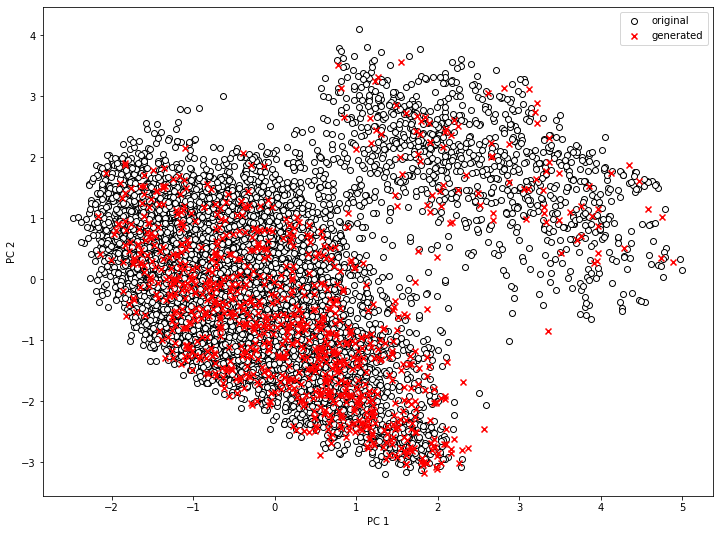

In [22]:
plt.figure(figsize=(12, 9))
plt.scatter(X[Vlen:, 0], X[Vlen:, 1], c='w', edgecolors='k', label='original')
plt.scatter(X[:Vlen, 0], X[:Vlen, 1], marker='x',c='r', label='generated')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In order to compare the generated molecules to the original molecules used for RNN training, 24 common physiochemical features for the data were calculated. PCA was performed on these 24 generated features from the training molecules, and the first two pricipal components (PC1, PC2) were selected. The coordinates of the generated molecules were transformed accordingly. Figure above shows that there is overlap in the chemical subspace between these two sets of molecules.

In [23]:
props = {
    'MW': {
        'generated': [Descriptors.ExactMolWt(mol) for mol in valid_mols],
        'original': [Descriptors.ExactMolWt(mol) for mol in org_mols]        
    }
}

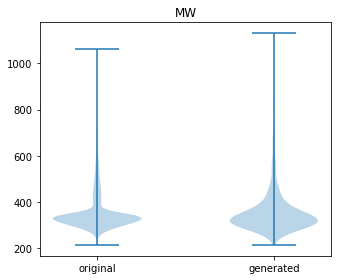

In [24]:
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.violinplot([props['MW']['original'], props['MW']['generated']])
ax1.set_xticks(ticks=[1, 2])
ax1.set_xticklabels(labels=['original', 'generated'])
ax1.set_title('MW')


plt.tight_layout()

Violin plots for molecular weight (MW) distributions. Visual inspection reveals a close match of the generated and original molecules.

Molecular mass - Mass of a given molecule. Different molecules of the same compound may have different molecular masses because they contain different isotopes of an element.

# 5. Use transfer learning to fine-tune model

In [25]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

In [26]:
config = process_config('experiments/base_experiment/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/base_experiment/LSTM_Chem/model_arch.json ...


100%|██████████| 6/6 [00:00<00:00, 1928.71it/s]

Loading model checkpoint from experiments/base_experiment/LSTM_Chem/checkpoints/LSTM_Chem-baseline-model-full.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...
done.
Epoch 1/12


6/6 [==============================] - 3s 435ms/step - loss: 1.6474
Epoch 2/12
6/6 [==============================] - 3s 497ms/step - loss: 1.2864
Epoch 3/12
6/6 [==============================] - 3s 425ms/step - loss: 1.0573
Epoch 4/12
6/6 [==============================] - 2s 394ms/step - loss: 0.9538
Epoch 5/12
6/6 [==============================] - 3s 422ms/step - loss: 0.7695
Epoch 6/12
6/6 [==============================] - 2s 403ms/step - loss: 0.7268
Epoch 7/12
6/6 [==============================] - 3s 438ms/step - loss: 0.6180
Epoch 8/12
6/6 [==============================] - 3s 457ms/step - loss: 0.5752
Epoch 9/12
6/6 [==============================] - 3s 486ms/step - loss: 0.4966
Epoch 10/12
6/6 [==============================] - 3s 431ms/step - loss: 0.4824
Epoch 11/12
6/6 [==============================] - 3s 433ms/step - loss: 0.4144
Epoch 12/12
6/6 [==============================] - 2s 410ms/step - loss: 0.3770


In [35]:
# Experimented with a few no. of samples, 
# Larger no. seems to generate bigger, weird molecules,
# Smaller number could cause repeating molecules

finetuned_smiles = finetuner.sample(num=25) 

In [36]:
finetuned_smiles

['Cc1c(O)cccc1C(=O)NC(Cc1ccccc1)C(NC(=O)OCc1ccc(N)cc1)C(O)C(NC(=O)OCC(Cc1ccccc1)NC(=O)OCc1ccccc1)C(C)(C)C',
 'COC(=O)NCCCC(O)NC(=O)C(CS(=O)(=O)O)NC(=O)C(CNC(=O)C(C)(C)N)N1CC(C)CC1C',
 'CC(C)(C)NC(=S)C(C(C#CCc1ccccc1)NC(=O)OC1CCCCC1)C(O)C(Cc1ccccc1)NC(=O)C(C)(C)C',
 'CC(C)CC(C(=O)NC(Cc1ccccc1)C(C(CO)NC(=CCc1ccccc1)NC(=O)OC1COC1)S(C)(=O)=O)C(O)C(C)(C)C',
 'CC(C)(O)C(=O)NC(Cc1ccccc1)C(c1ccccc1)C(Cc1ccccc1)NC(=O)OC1COC1C[SH](C)(=O)O',
 'Cc1cccc(C)c1OCC(=O)NC(Cc1ccccc1)C(NC(=O)C(NC(=O)OCc1ccccn1)C(C)C)C(C)(C)C',
 'CC(C)CN(CC(NC(=O)OC(C)(C)C)C(Cc1ccccc1)c1ccccc1)[SH](C)(=O)C(C(=O)NC(C)(C)O)C(C)(C)C',
 'CC(C)C(O)=NOC(Cc1ccccc1)C(=Cc1ccccc1)NC(=O)OC1CCCN1C(=O)C(NC(=O)C(NC(=O)OC(C)(C)C)C(C)C)C(C)C',
 'CC1=C2CN3CC3=CC=CC=CC=CC=CC=C1CC2C(C(=O)NC(C)(C)C)C(C)(C)C',
 'CC(C)C1=CC(C(C(=N)N)C(=O)NC(Cc2ccccc2)C(CC(CC(c2ccccc2)C(C)C)NC(=O)OCc2ccccc2)NC(=O)OC2CCCCC2)C1',
 'CC1=CCCC2CC(C)(C)C3CCC4C5CCC4(C)C4CC6CC(CCC7C(C=CC=CC=C3COC(=O)NC(C(C)(C)C)C(=O)NC7C)CC125)CC6C4O',
 'CC(C)C1=NC(C(O)CN(Cc2ccccc2)NC(=

In [81]:
# Selected training molecules

with open('./datasets/protease_inhibitors_for_fine-tune.txt') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Fbvs = []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)

In [82]:
# Fine-tuned SMILES

Sbvs, smols = [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)

In [83]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [84]:
idxs

[0, 1, 1, 3, 4, 3]

In [85]:
finetuned_smiles = [finetuned_smiles[i] for i in idxs]
finetuned_smiles

['Cn1c(COC(=O)NC(C(=O)OC(C(=O)NC(Cc2ccccc2)C(O)C(CC(O)CO)NC(=O)OC(C)(C)C)C(C)(C)C)C(C)(C)C)cnc1N=NN',
 'Cc1c(O)cccc1C(=O)NC(Cc1ccccc1)C(O)CN(CC(Cc1ccccc1)NC(=O)C(C(C)C)N1CCOCC1)C(C(C)C)N1CCNCC1',
 'Cc1c(O)cccc1C(=O)NC(Cc1ccccc1)C(O)CN(CC(Cc1ccccc1)NC(=O)C(C(C)C)N1CCOCC1)C(C(C)C)N1CCNCC1',
 'Cc1ccccc1C(=O)NC(CS)CC(=O)NC(Cc1ccccc1)C(CCCNC(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)CN1CCCCC1',
 'CC(C)(O)C(=O)NC(Cc1ccccc1)C(c1ccccc1)C(Cc1ccccc1)NC(=O)OC1COC1C[SH](C)(=O)O',
 'Cc1ccccc1C(=O)NC(CS)CC(=O)NC(Cc1ccccc1)C(CCCNC(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)CN1CCCCC1']

In [40]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

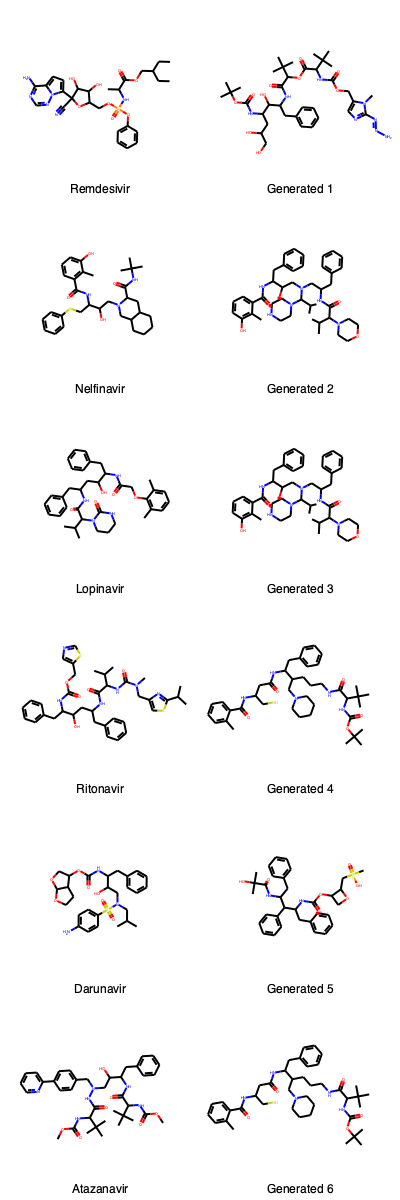

In [42]:
# Labels
labelList = ['Remdesivir', 'Generated 1',
             'Nelfinavir','Generated 2', 
             'Lopinavir','Generated 3',
             'Ritonavir','Generated 4',
             'Darunavir','Generated 5',
             'Atazanavir', 'Generated 6']

# Display molecules with labels
Draw.MolsToGridImage(showmols, molsPerRow=2, legends=[label for label in labelList])

Generated structures with highest Tanimoto similarity to the known protease inhibitors.

The seven potential protease inhibitors of COVID-19 used to fine-tune the RNN model are shown on the left. The respective generated molecule with highest Tanimoto similarity (nearest neighbor) is shown on the right of every reference compound.

The Tanimoto coefficient T is the most popular similarity measure for comparing chemical structures represented by means of fingerprints.

In [86]:
finetuned_smiles

['Cn1c(COC(=O)NC(C(=O)OC(C(=O)NC(Cc2ccccc2)C(O)C(CC(O)CO)NC(=O)OC(C)(C)C)C(C)(C)C)C(C)(C)C)cnc1N=NN',
 'Cc1c(O)cccc1C(=O)NC(Cc1ccccc1)C(O)CN(CC(Cc1ccccc1)NC(=O)C(C(C)C)N1CCOCC1)C(C(C)C)N1CCNCC1',
 'Cc1c(O)cccc1C(=O)NC(Cc1ccccc1)C(O)CN(CC(Cc1ccccc1)NC(=O)C(C(C)C)N1CCOCC1)C(C(C)C)N1CCNCC1',
 'Cc1ccccc1C(=O)NC(CS)CC(=O)NC(Cc1ccccc1)C(CCCNC(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)CN1CCCCC1',
 'CC(C)(O)C(=O)NC(Cc1ccccc1)C(c1ccccc1)C(Cc1ccccc1)NC(=O)OC1COC1C[SH](C)(=O)O',
 'Cc1ccccc1C(=O)NC(CS)CC(=O)NC(Cc1ccccc1)C(CCCNC(=O)C(NC(=O)OC(C)(C)C)C(C)(C)C)CN1CCCCC1']

In [77]:
f = open("./datasets/protease_inhibitors_for_fine-tune.txt", "r")
print(f.read())

CCC(CC)COC(=O)C(C)NP(=O)(OCC1C(C(C(O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4
CC1=C(C=CC=C1O)C(=O)NC(CSC2=CC=CC=C2)C(CN3CC4CCCCC4CC3C(=O)NC(C)(C)C)O
CC1=C(C(=CC=C1)C)OCC(=O)NC(CC2=CC=CC=C2)C(CC(CC3=CC=CC=C3)NC(=O)C(C(C)C)N4CCCNC4=O)O
CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O
CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2COC3C2CCO3)O)S(=O)(=O)C4=CC=C(C=C4)N
CC(C)(C)C(C(=O)NC(CC1=CC=CC=C1)C(CN(CC2=CC=C(C=C2)C3=CC=CC=N3)NC(=O)C(C(C)(C)C)NC(=O)OC)O)NC(=O)OC



ID, smiles, source, score

In [94]:
def write_to_pdb(m, name):
    m = Chem.AddHs(m)
    Chem.EmbedMolecule(m)
    w = Chem.rdmolfiles.PDBWriter(open("Docking/"+ str(name) + ".pdb", "w"))
    w.write(m)

In [95]:
for i in range(len(finetuned_smiles)):
    write_to_pdb(finetuned_smiles[i], "bp_" + str(i+1))

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.AddHs(str)
did not match C++ signature:
    AddHs(RDKit::ROMol mol, bool explicitOnly=False, bool addCoords=False, boost::python::api::object onlyOnAtoms=None, bool addResidueInfo=False)

In [96]:
generated = pickle.load(open("./datasets/protease_inhibitors_for_fine-tune.txt", "rb"))
generated = [Chem.MolFromSmiles(x) for x in generated]

NameError: name 'pickle' is not defined

In [ ]:
for i in [5,6,9,32,33,34,36,38,43,44]:
    write_to_pdb(generated[i], str(i))

### Docking procedure with Autodock Vina:

1. Open the structure of the protein and ligand complex (.cif crystallographic information file) https://www.rcsb.org/3d-view/6LU7
2. Select the ligand chain, delete the ligand, and save the file as a .pdb

# Future Work
- select high binding scores candidates to re-train
- increase generations
- Run generated smiles, hiv inhibitors, remdesivir in PyRx and get binding score

follow my github for updates

# Questions

- How can I improve this work?
- What questions are likely being asked?